In [1]:
import itertools
import os

import numpy as np
import pandas as pd
from plotnine import *

In [39]:
fuzzers = ['zest', 'zest-original', 'bedivfuzz-split', 'bedivfuzz-split-original']
subjects = ['ant', 'bcel', 'chocopy', 'closure', 'maven', 'nashorn', 'pngj', 'rhino', 'tomcat']
num_trials = 30
timeout = 180

In [40]:
def trial_df(experiment_name: str, fuzzer: str, subject: str, trial: int):
    df = pd.read_csv(
        os.path.join('results', experiment_name, fuzzer, subject, f'trial-{trial}', 'plot_data'),
        skipinitialspace=True
    )

    if 'bedivfuzz-split' in fuzzer:
        zest_plot_data = pd.read_csv(
            os.path.join('results', experiment_name , fuzzer, subject, f'trial-{trial}', 'zest-results', 'plot_data'),
            skipinitialspace=True
        )

        df = pd.concat([zest_plot_data, df], ignore_index=True)

    # one datapoint per minute
    df = df.loc[np.linspace(0, len(df)-1, timeout, endpoint=True, dtype=np.int64)]
    df['time'] = range(1, timeout+1)
    df['trial'] = trial
    df['fuzzer'] = fuzzer
    df['subject'] = subject
    df['validity_rate'] = df['valid_inputs'] / (df['valid_inputs'] + df['invalid_inputs'])

    if 'unique_valid_paths' in df.columns:
        return df[[
            'fuzzer', 'subject', 'trial', 'time', 
            'valid_inputs', 'invalid_inputs', 'validity_rate', 'unique_paths', 'unique_valid_paths',
            'num_coverage_probes', 'num_semantic_probes', 'b0', 'b1', 'b2'
        ]]

    else:
        return df[[
                'fuzzer', 'subject', 'trial', 'time', 
                'valid_inputs', 'invalid_inputs', 'validity_rate', 'unique_paths',
                'num_coverage_probes', 'num_semantic_probes', 'b0', 'b1', 'b2'
            ]]

In [41]:
def load_results(experiment_name):
    dfs = []
    for f, s, t in itertools.product(fuzzers, subjects, range(1, num_trials+1)):
        dfs.append(trial_df(experiment_name, fuzzer=f, subject=s, trial=t))
    trials = pd.concat(dfs)
    return trials

In [50]:
trials = load_results('eval-bedivfuzz-split-3h/default')

In [58]:
metric = 'b1'
mean_thesis_default = trials.groupby(['fuzzer', 'subject', 'time'])[metric].agg(mean_score='mean', sem=lambda y: y.std() / np.sqrt(len(y)))
mean_thesis_default['min_score'] = mean_thesis_default['mean_score'] - mean_thesis_default['sem']
mean_thesis_default['max_score'] = mean_thesis_default['mean_score'] + mean_thesis_default['sem']

/Users/lam/_projects/bedivfuzz/.venv/lib/python3.11/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



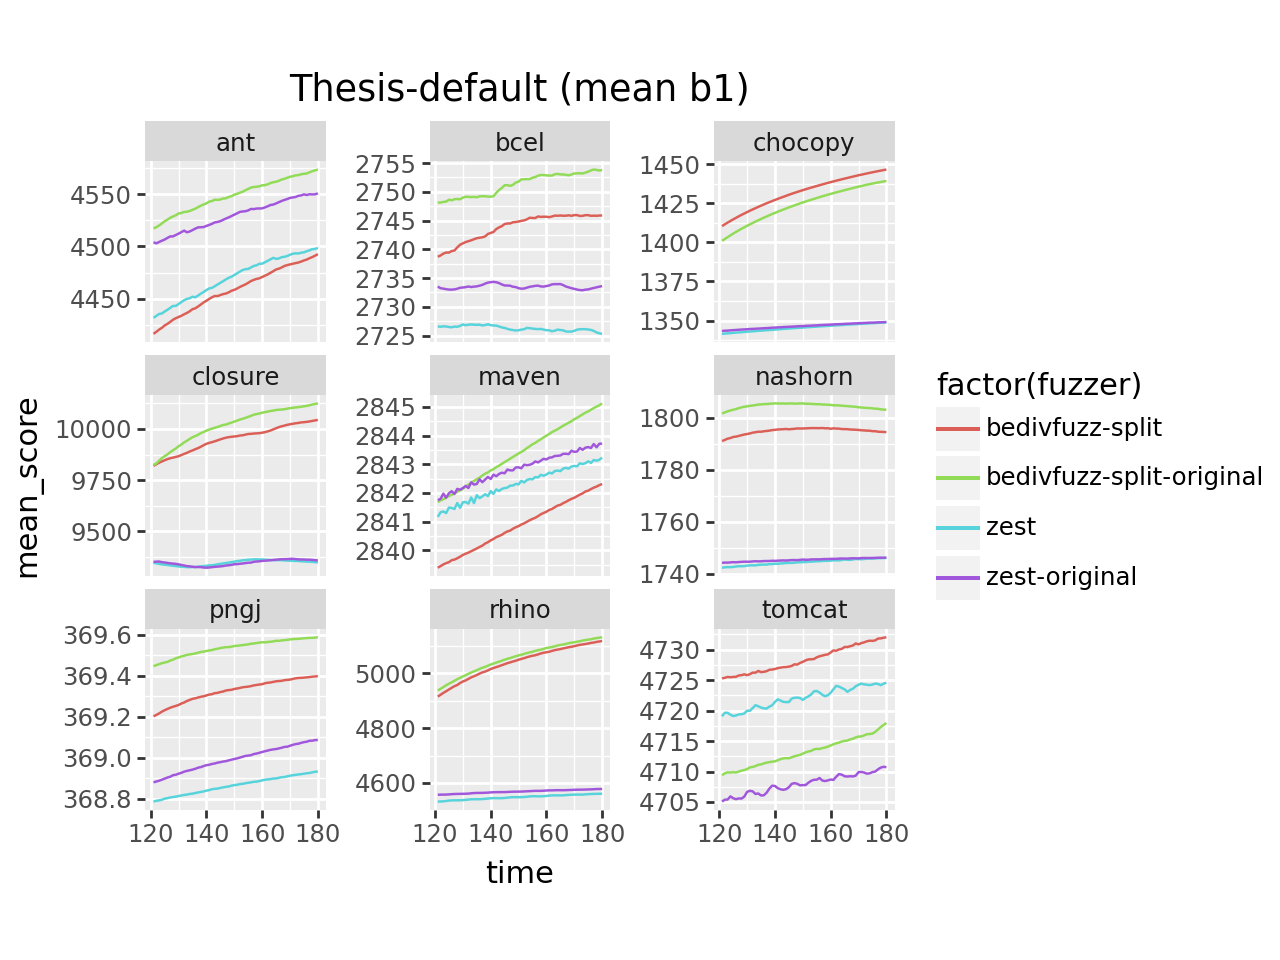

In [59]:
(ggplot(mean_thesis_default.reset_index().query("time > 120"), aes("time", "mean_score", color="factor(fuzzer)", fill="factor(fuzzer)"))
 + geom_line()
 #+ geom_ribbon(aes(ymin = "min_score", ymax = "max_score"), alpha = 0.2)
 + facet_wrap("~subject", scales="free_y")
 + theme(aspect_ratio = 1.0)
 + ggtitle(f"Thesis-default (mean {metric})")
)

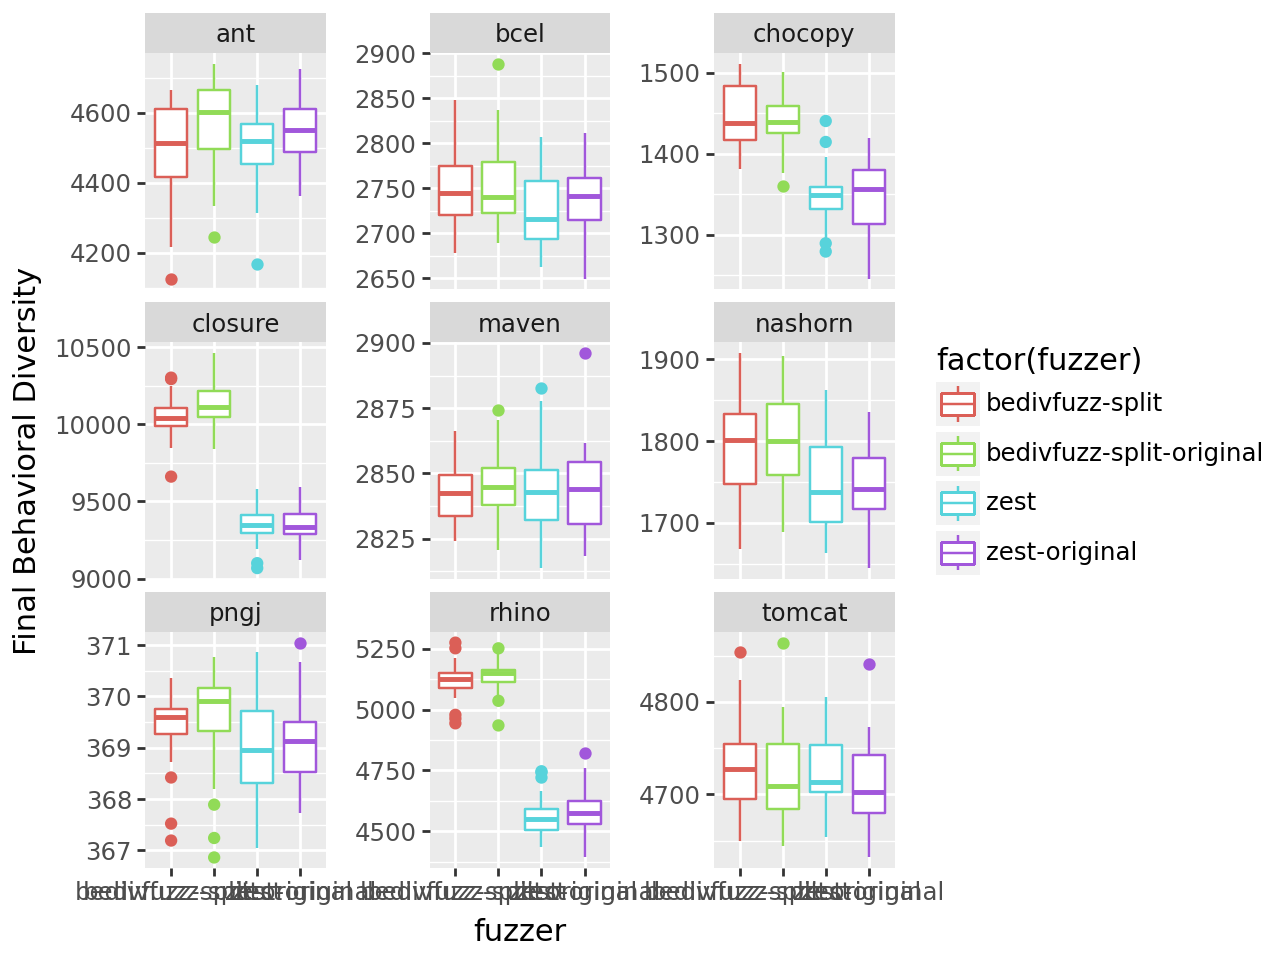

In [54]:
final_scores = trials.loc[trials['time'] == 180]

(ggplot(final_scores, aes("fuzzer", "b1", color="factor(fuzzer)"))
 + geom_boxplot()
 + facet_wrap("~subject", scales="free_y")
 + ylab("Final Behavioral Diversity")
)

In [8]:
trials.loc[trials['time'] == 180]

,fuzzer,subject,trial,time,valid_inputs,invalid_inputs,validity_rate,unique_paths,unique_valid_paths,num_coverage_probes,num_semantic_probes,b0,b1,b2
3410,zest,ant,1,180,23252,204620,0.102040,82238,14413,128171,92573,6799.0,4362.16,4136.16
3391,zest,ant,2,180,25064,67869,0.269700,50411,16394,128201,92655,6238.0,4619.30,4453.97
3389,zest,ant,3,180,28162,67120,0.295565,48153,18463,128201,92655,6239.0,4611.85,4449.71
3383,zest,ant,4,180,23166,64679,0.263714,52402,15667,127944,92014,6869.0,4635.02,4459.46
3378,zest,ant,5,180,25785,91207,0.220400,63386,17260,127855,91830,6238.0,4487.60,4282.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3586,bedivfuzz-split,tomcat,16,180,817803,59202,0.932495,604823,563501,94960,10694,7355.0,4657.81,4505.45
3584,bedivfuzz-split,tomcat,17,180,639195,78672,0.890409,527117,469528,94960,10694,6768.0,4731.44,4564.12
3585,bedivfuzz-split,tomcat,18,180,585065,132010,0.815905,505681,414433,94960,10694,7353.0,4863.98,4679.46
3585,bedivfuzz-split,tomcat,19,180,667666,80689,0.892178,539666,483636,94960,10694,7306.0,4730.69,4565.45


In [9]:
import scipy.stats as stats

In [10]:
metric = 'b1'
alpha = 0.01
time = 180
for s in subjects:
    x = trials.query(f"fuzzer == 'zest' and subject == '{s}' and time == {time}")[metric].to_numpy()
    y = trials.query(f"fuzzer == 'bedivfuzz-split' and subject == '{s}' and time == {time}")[metric].to_numpy()

    if stats.mannwhitneyu(x, y, alternative='two-sided').pvalue < alpha:
        print(f"{s.ljust(10)}: {'zest' if np.mean(x) > np.mean(y) else 'bedivfuzz'}")
    else:
        print(f"{s.ljust(10)}: not significant")


ant       : not significant
bcel      : not significant
chocopy   : bedivfuzz
closure   : bedivfuzz
maven     : not significant
nashorn   : bedivfuzz
pngj      : not significant
rhino     : bedivfuzz
tomcat    : not significant


In [63]:
results_base_dir = os.path.join('results', 'eval-bedivfuzz-split-3h', 'default')

In [64]:
import math

crash_to_id = {}
def deduplicate_crash(exception_class, stack_trace):
    key = (exception_class, '-'.join(str(stack_trace).split('-')[:3]))
    if str(exception_class) == 'nan' or "OutOfMemoryError" in str(exception_class):
        return -1
    if key in crash_to_id.keys():
        return crash_to_id[key]
    else:
        crash_id = len(crash_to_id)
        crash_to_id[key] = crash_id
        return crash_id

In [65]:
def crash_trial_df(fuzzer: str, subject: str, trial: int):
    df = pd.read_csv(
        os.path.join(results_base_dir, fuzzer, subject, f'trial-1', 'failure_info.csv'),
        skipinitialspace=True
    )

    df['trial'] = trial
    df['fuzzer'] = fuzzer
    df['subject'] = subject
    df['crash_id'] = df.apply(lambda row: deduplicate_crash(row['exception_class'], row['top5_stack_trace']), axis=1)

    return df[['fuzzer', 'subject', 'trial', '# ttd', 'exception_class', 'crash_id']]

In [66]:
crash_dfs = []
for f, s, t in itertools.product(fuzzers, subjects, range(1, num_trials+1)):
    crash_dfs.append(crash_trial_df(fuzzer=f, subject=s, trial=t))
crash_trials = pd.concat(crash_dfs)

In [67]:
crash_trials = crash_trials.loc[crash_trials['crash_id'] != -1]

In [68]:
crash_trials.groupby(['subject', 'fuzzer'])['# ttd'].agg('median').round(0).astype(int)

subject  fuzzer                  
bcel     bedivfuzz-split             2465973
         zest                        1637493
         zest-original               5136389
closure  bedivfuzz-split             3175051
         bedivfuzz-split-original    1181772
         zest                        1923549
         zest-original               2666400
nashorn  bedivfuzz-split              237137
         bedivfuzz-split-original     284222
         zest                        2976656
         zest-original               3981318
rhino    bedivfuzz-split             1502000
         bedivfuzz-split-original    1143016
         zest                        4066527
         zest-original               3218541
Name: # ttd, dtype: int64

In [69]:
crash_trials.groupby(['subject', 'fuzzer'])['crash_id'].agg('nunique')

subject  fuzzer                  
bcel     bedivfuzz-split             2
         zest                        1
         zest-original               1
closure  bedivfuzz-split             3
         bedivfuzz-split-original    4
         zest                        4
         zest-original               3
nashorn  bedivfuzz-split             6
         bedivfuzz-split-original    5
         zest                        6
         zest-original               6
rhino    bedivfuzz-split             5
         bedivfuzz-split-original    3
         zest                        2
         zest-original               2
Name: crash_id, dtype: int64

In [70]:
# Deduplicate bugs
crash_trials.groupby(['subject', 'fuzzer', 'trial', 'crash_id'])['# ttd'].agg('min')\
    .groupby(['subject', 'fuzzer', 'crash_id']).agg('mean').round(0).astype(int)

subject  fuzzer                    crash_id
bcel     bedivfuzz-split           0.0          403343
                                   14.0         737487
         zest                      0.0         1011777
         zest-original             0.0         5136389
closure  bedivfuzz-split           1.0         1324410
                                   4.0          560017
                                   15.0         977033
         bedivfuzz-split-original  1.0          496391
                                   3.0          673854
                                   4.0          488741
                                   15.0         496759
         zest                      1.0          841769
                                   2.0         1379708
                                   3.0         1424079
                                   4.0         2524541
         zest-original             1.0         2666400
                                   2.0         4197334
                     

In [37]:
crash_to_id

{('class org.apache.bcel.verifier.exc.AssertionViolatedException',
  'org.apache.bcel.util.ClassPath.getClassFile(ClassPath.java:656)-org.apache.bcel.util.ClassPath.getInputStream(ClassPath.java:705)-org.apache.bcel.util.ClassPath.getInputStream(ClassPath.java:679)'): 0,
 ('class org.apache.bcel.verifier.exc.AssertionViolatedException',
  'java.base/jdk.internal.util.Preconditions.outOfBounds(Preconditions.java:64)-java.base/jdk.internal.util.Preconditions.outOfBoundsCheckIndex(Preconditions.java:70)-java.base/jdk.internal.util.Preconditions.checkIndex(Preconditions.java:248)'): 1,
 ('class java.lang.IllegalStateException',
  'com.google.javascript.jscomp.jarjar.com.google.common.base.Preconditions.checkState(Preconditions.java:590)-com.google.javascript.jscomp.LightweightMessageFormatter.padMultipleLines(LightweightMessageFormatter.java:237)-com.google.javascript.jscomp.LightweightMessageFormatter.getExcerptWithPosition(LightweightMessageFormatter.java:169)'): 2,
 ('class java.lang.Nu

In [38]:
crash_trials.groupby(['subject', 'fuzzer'])['crash_id'].unique()

subject  fuzzer   
bcel     zest                        [0.0, 1.0]
closure  bedivfuzz                   [5.0, 2.0]
         zest         [2.0, 3.0, 4.0, 5.0, 6.0]
rhino    bedivfuzz              [9.0, 8.0, 7.0]
         zest                        [7.0, 8.0]
Name: crash_id, dtype: object

In [39]:
crash_trials.groupby(['subject', 'fuzzer', 'trial', 'crash_id'])['# ttd'].agg('min')\
   .groupby(['subject', 'fuzzer', 'crash_id']).agg('count')

subject  fuzzer     crash_id
bcel     zest       0.0         10
                    1.0         10
closure  bedivfuzz  2.0         10
                    5.0         10
         zest       2.0         10
                    3.0         10
                    4.0         10
                    5.0         10
                    6.0         10
rhino    bedivfuzz  7.0         10
                    8.0         10
                    9.0         10
         zest       7.0         10
                    8.0         10
Name: # ttd, dtype: int64